# Klasifikasi kualitas air menggunakan metode Decision Tree

In [5]:
#library yang digunakan
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## dataset



data diperloeh dari kaggle dengan nama ["water quality"](https://www.kaggle.com/datasets/adityakadiwal/water-potability)

In [6]:
data = pd.read_csv("water_potabilitys.csv")

## pemahaman data

dataset ini berjumlah 3276 data dan memiliki 9 fitur dengan 1 target yaitu potability, berikut adalah fitur-fitur yang terdapat di dalamnya:
-	ph: kandungan pH air (0 hingga 14).
-	Hardnes: Kapasitas air untuk mengendapkan sabun dalam mg/L.
-	Solid: Total padatan terlarut dalam ppm.
-	chloramine: Jumlah Kloramin dalam ppm.
-	Sulfate: Jumlah Sulfat yang terlarut dalam mg/L.
-	Conductivity: Konduktivitas listrik air dalam μS/cm.
-	Organic_carbon: Jumlah karbon organik dalam ppm.
-	Trihalomethanes: Jumlah Trihalomethanes dalam μg/L.
-	Turbidity: Ukuran sifat air yang memancarkan cahaya di NTU.
-	Potability: Menunjukkan apakah air aman untuk dikonsumsi manusia. Dapat diminum -1 dan Tidak dapat diminum -0

In [7]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [8]:
data.groupby('Potability').size()

Potability
0    1998
1    1278
dtype: int64

In [9]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

## Preprocessing data
Proses preprocessing adalah proses untuk membuat dataset menjadi lebih baik, dataset akan dilakukan pembersihan atau pengimputan data dan pemrosesan lainnya seperti mencari outlier, keseimbangan data, normalisasi data dengan tujuan untuk membuat data semakin baik.
pada penelitian ini akan dilakukan pengimputan data untuk missing dengan nilai rata-rata dan KNN yang nantinya akan dilakukan perbandingan lebih bagus mana antara data yang diimput dengan nilai rata-rata atau KNN, kemudian juga akan dilakukan normalisasi data dengan metode minmax kemudian akan dilakukan penyeimbangan data dengan metode SMOTE

In [10]:
X = data.drop(columns=['Potability'])
y = data['Potability']

### Imputasi Missing value
proses untuk menginput nilai yang kosong atau hilang, proses dapat dilakukan oleh beberapa metode,seperti pada penilitian ini teradpat 2 metode yang digunakna yaitu mengisi nilai kosong dengan nilai rata rata dan mengisi nilai kosong dengan metode knn.

#### rata-rata
nilai kosong akan diisin oleh nilai rata-rata pada fitur yang memiliki nilai kosong
#### knn imputasi
nilai kosong akan diisi dengan metode knn imputasi, dimana program akan mencari tetangga terdekat, pada penelitian ini yang bagus yaitu menggunakan 10 tetangga terdekat(percobaan manual), kemudian tetangga terdekat tersebut akan di cari nilai rata-ratanya dan nilai kosong akan diisikan oleh nilai rata-rata dari tetangga tersebut.      
rumus knn untuk imputasi:

$$
X = \frac{1}{K} \sum_{k=1}^{K} X_{k}
$$

In [11]:
Xrata = X.fillna(X.mean())
imputer = KNNImputer(n_neighbors=10)
Xknn = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

### normalisasi data
normalisasi data adalah proses membuat dataset yang awalnya memiliki rentang nilai jauh berbeda menjadi rentang nilai yang sama, metode yang digunakan di sini yaitu min-max scaler dimana data akan di ubah menjadi nilai dengan rentang 1-0.

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
Xrata= pd.DataFrame(scaler.fit_transform(Xrata), columns=X.columns)
Xknn= pd.DataFrame(scaler.fit_transform(Xknn), columns=X.columns)

#### penyeimbangan data
penyeimbangan data adalah proses untuk membuat data menjadi seimbang, pada penelitian dataset yang digunakan memiliki kelas 0 sebanyak 0.61 dan kelas 1 sebanyak 0.39 maka dari itu diperlukan penanganan dalam ketidak seimbangan data, begitupun karena decision tree adalah metode yang sensitif terhadap data tidak seimbang.       
langkah-langkah = 
- mencari tetangga terderat
- membuat data sintesis dengan rumus $ x_{\text{sintetik}} = x_i + \lambda \cdot (x_k - x_i) $


In [13]:
smote = SMOTE(random_state=42)
Xrata, yrata = smote.fit_resample(Xrata, y)
Xknn, yknn = smote.fit_resample(Xknn, y)

## Pemodelan
Proses modelling dalam analisis data adalah langkah penting di mana Anda menggunakan berbagai teknik statistik atau algoritma machine learning untuk memahami, menganalisis,  memprediksi pola dalam data. Dikarenakan dalam Case Datasets Water Quality ini tujuannya untuk menentukan kategori dari pengelompokan terkena diabetes jadi tentunya kita menggunakan Metode Klasifikasi. Metode yang digunakan Disini yaitu menggunakan model decision tree dan naive baiyes sebagai pembanding

### spliting data
proses untuk membagi data menjadi data latih dan data tes, data latih akan dilatih dengan model untuk mendapatkan fungsi prediksi yang dimana nantinya fungsi akan digunakan oleh data tes, pada dataset ini akan dibagi menjadi 20:80, tes 20 dan latih 80.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(Xknn, yknn, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(Xrata, yrata, test_size=0.2, random_state=42)

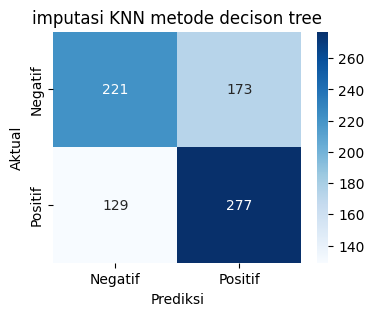

akurasi untuk data inputan knn dengan metode decison tree
Akurasi model: 0.62
Precision: 0.62
Recall: 0.68
F1 Score: 0.65


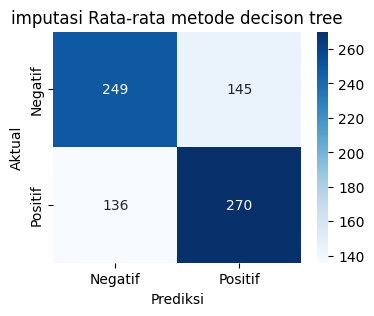

akurasi untuk data inputan rata-rata dengan metode decison tree
Akurasi model: 0.65
Precision: 0.65
Recall: 0.67
F1 Score: 0.66


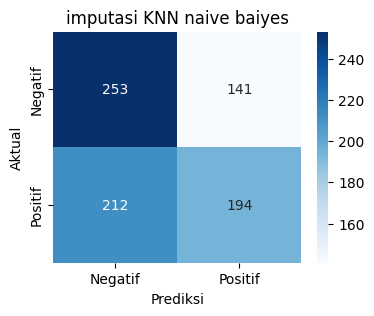

akurasi untuk data inputan knn dengan metode naive baiyes
Akurasi model: 0.56
Precision: 0.58
Recall: 0.48
F1 Score: 0.52


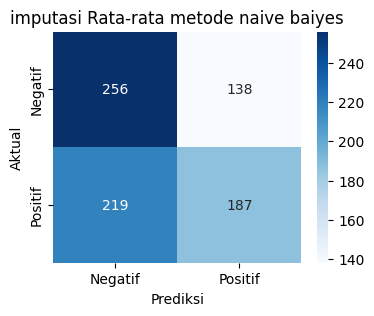

akurasi untuk data inputan rata-rata dengan metode naive baiyes
Akurasi model: 0.55
Precision: 0.58
Recall: 0.46
F1 Score: 0.51


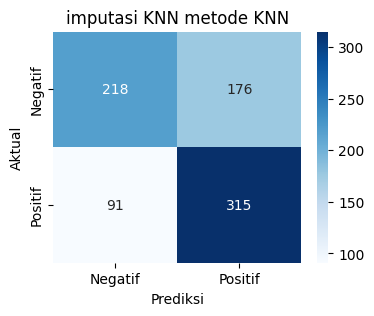

akurasi untuk data inputan knn dengan metode KNN
Akurasi model: 0.67
Precision: 0.64
Recall: 0.78
F1 Score: 0.70


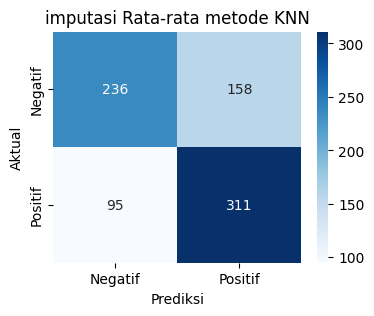

akurasi untuk data inputan rata-rata dengan metode KNN
Akurasi model: 0.68
Precision: 0.66
Recall: 0.77
F1 Score: 0.71


In [19]:
# data inputan knn dengan metode decison tree
X_train, X_test, y_train, y_test = train_test_split(Xknn, yknn, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred)
precision_1 = precision_score(y_test, y_pred)
recall_1 = recall_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])

plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('imputasi KNN metode decison tree')
plt.show()
print('akurasi untuk data inputan knn dengan metode decison tree')
print(f'Akurasi model: {accuracy_1:.2f}')
print(f'Precision: {precision_1:.2f}')
print(f'Recall: {recall_1:.2f}')
print(f'F1 Score: {f1_1:.2f}')

# data inputan rata-rata dengan metode decison tree
X_train, X_test, y_train, y_test = train_test_split(Xrata, yrata, test_size=0.2, random_state=42)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_2 = accuracy_score(y_test, y_pred)
precision_2 = precision_score(y_test, y_pred)
recall_2 = recall_score(y_test, y_pred)
f1_2 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])

plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('imputasi Rata-rata metode decison tree')
plt.show()
print('akurasi untuk data inputan rata-rata dengan metode decison tree')
print(f'Akurasi model: {accuracy_2:.2f}')
print(f'Precision: {precision_2:.2f}')
print(f'Recall: {recall_2:.2f}')
print(f'F1 Score: {f1_2:.2f}')

# data inputan knn dengan metode naive baiyes
X_train, X_test, y_train, y_test = train_test_split(Xknn, yknn, test_size=0.2, random_state=42)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_3 = accuracy_score(y_test, y_pred)
precision_3 = precision_score(y_test, y_pred)
recall_3 = recall_score(y_test, y_pred)
f1_3 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])

plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('imputasi KNN naive baiyes')
plt.show()
print('akurasi untuk data inputan knn dengan metode naive baiyes')
print(f'Akurasi model: {accuracy_3:.2f}')
print(f'Precision: {precision_3:.2f}')
print(f'Recall: {recall_3:.2f}')
print(f'F1 Score: {f1_3:.2f}')

# data inputan rata-rata dengan metode naive baiyes
X_train, X_test, y_train, y_test = train_test_split(Xrata, yrata, test_size=0.2, random_state=42)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_4 = accuracy_score(y_test, y_pred)
precision_4 = precision_score(y_test, y_pred)
recall_4 = recall_score(y_test, y_pred)
f1_4 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])

plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('imputasi Rata-rata metode naive baiyes')
plt.show()
print('akurasi untuk data inputan rata-rata dengan metode naive baiyes')
print(f'Akurasi model: {accuracy_4:.2f}')
print(f'Precision: {precision_4:.2f}')
print(f'Recall: {recall_4:.2f}')
print(f'F1 Score: {f1_4:.2f}')

# data inputan knn dengan metode KNN
X_train, X_test, y_train, y_test = train_test_split(Xknn, yknn, test_size=0.2, random_state=42)
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_5 = accuracy_score(y_test, y_pred)
precision_5 = precision_score(y_test, y_pred)
recall_5 = recall_score(y_test, y_pred)
f1_5 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])

plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('imputasi KNN metode KNN')
plt.show()
print('akurasi untuk data inputan knn dengan metode KNN')
print(f'Akurasi model: {accuracy_5:.2f}')
print(f'Precision: {precision_5:.2f}')
print(f'Recall: {recall_5:.2f}')
print(f'F1 Score: {f1_5:.2f}')

# data inputan rata-rata dengan metode KNN
X_train, X_test, y_train, y_test = train_test_split(Xrata, yrata, test_size=0.2, random_state=42)
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_6 = accuracy_score(y_test, y_pred)
precision_6 = precision_score(y_test, y_pred)
recall_6 = recall_score(y_test, y_pred)
f1_6 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])

plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('imputasi Rata-rata metode KNN')
plt.show()
print('akurasi untuk data inputan rata-rata dengan metode KNN')
print(f'Akurasi model: {accuracy_6:.2f}')
print(f'Precision: {precision_6:.2f}')
print(f'Recall: {recall_6:.2f}')
print(f'F1 Score: {f1_6:.2f}')


In [29]:
accuracy_knn_decision_tree = round(accuracy_1,2)
precision_knn_decision_tree = round(precision_1,2)
recall_knn_decision_tree = round(recall_1,2)
f1_knn_decision_tree = round(f1_1,2)

accuracy_rata_decision_tree = round(accuracy_2,2)
precision_rata_decision_tree = round(precision_2,2)
recall_rata_decision_tree = round(recall_2,2)
f1_rata_decision_tree = round(f1_2,2)

accuracy_knn_naive_bayes = round(accuracy_3,2)
precision_knn_naive_bayes = round(precision_3,2)
recall_knn_naive_bayes = round(recall_3,2)
f1_knn_naive_bayes = round(f1_3,2)

accuracy_rata_naive_bayes = round(accuracy_4,2)
precision_rata_naive_bayes = round(precision_4,2)
recall_rata_naive_bayes = round(recall_4,2)
f1_rata_naive_bayes = round(f1_4,2)

accuracy_knn_KNN = round(accuracy_5,2)
precision_knn_KNN = round(precision_5,2)
recall_knn_KNN = round(recall_5,2)
f1_knn_KNN = round(f1_5,2)

accuracy_rata_KNN = round(accuracy_6,2)
precision_rata_KNN = round(precision_6,2)
recall_rata_KNN = round(recall_6,2)
f1_rata_KNN = round(f1_6,2)

data = {
    'Model': [
        'Decision Tree dengan Imputasi KNN',
        'Decision Tree dengan Imputasi Nilai Rata-rata',
        'Naive Bayes dengan Imputasi KNN',
        'Naive Bayes dengan Imputasi Nilai Rata-rata',
        'KNN dengan Imputasi KNN',
        'KNN dengan Imputasi Nilai Rata-rata'
    ],
    'Akurasi': [
        accuracy_knn_decision_tree,
        accuracy_rata_decision_tree,
        accuracy_knn_naive_bayes,
        accuracy_rata_naive_bayes,
        accuracy_knn_KNN,
        accuracy_rata_KNN
    ],
    'Precision': [
        precision_knn_decision_tree,
        precision_rata_decision_tree,
        precision_knn_naive_bayes,
        precision_rata_naive_bayes,
        precision_knn_KNN,
        precision_rata_KNN
    ],
    'Recall': [
        recall_knn_decision_tree,
        recall_rata_decision_tree,
        recall_knn_naive_bayes,
        recall_rata_naive_bayes,
        recall_knn_KNN,
        recall_rata_KNN
    ],
    'F1 Score': [
        f1_knn_decision_tree,
        f1_rata_decision_tree,
        f1_knn_naive_bayes,
        f1_rata_naive_bayes,
        f1_knn_KNN,
        f1_rata_KNN
    ]
}

perbandingan = pd.DataFrame(data)
print(perbandingan)


                                           Model  Akurasi  Precision  Recall  \
0              Decision Tree dengan Imputasi KNN     0.62       0.62    0.68   
1  Decision Tree dengan Imputasi Nilai Rata-rata     0.65       0.65    0.67   
2                Naive Bayes dengan Imputasi KNN     0.56       0.58    0.48   
3    Naive Bayes dengan Imputasi Nilai Rata-rata     0.55       0.58    0.46   
4                        KNN dengan Imputasi KNN     0.67       0.64    0.78   
5            KNN dengan Imputasi Nilai Rata-rata     0.68       0.66    0.77   

   F1 Score  
0      0.65  
1      0.66  
2      0.52  
3      0.51  
4      0.70  
5      0.71  
